In [2]:
!pip list

Package                  Version              
------------------------ ---------------------
absl-py                  0.8.0                
alabaster                0.7.12               
albumentations           0.1.12               
altair                   3.2.0                
astor                    0.8.0                
astropy                  3.0.5                
atari-py                 0.1.15               
atomicwrites             1.3.0                
attrs                    19.1.0               
audioread                2.1.8                
autograd                 1.3                  
Babel                    2.7.0                
backcall                 0.1.0                
backports.tempfile       1.0                  
backports.weakref        1.0.post1            
beautifulsoup4           4.6.3                
bleach                   3.1.0                
blis                     0.2.4                
bokeh                    1.0.4                
boto         

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
cd /content/gdrive

/content/gdrive


In [0]:
import copy
import time
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import relu as relu
import torch.optim as optim
from torch.autograd import Variable
import gym
from gym import wrappers

In [0]:
env = gym.make("CartPole-v0")

num_obs = env.observation_space.shape[0]
num_acts = env.action_space.n
hidden = 200

print(num_obs, hidden, num_acts)

4 200 2


In [0]:
class Q(nn.Module):
  def __init__(self):
    super(Q, self).__init__()
    self.fc1 = nn.Linear(num_obs, hidden)
    self.fc2 = nn.Linear(hidden, hidden)
    self.fc3 = nn.Linear(hidden, hidden)
    self.fc4 = nn.Linear(hidden, num_acts)
    
  def forward(self, x):
    x = relu(self.fc1(x))
    x = relu(self.fc2(x))
    x = relu(self.fc3(x))
    x = relu(self.fc4(x))
    return x

In [0]:
num_epoch = 3000
max_step = 200
memory_size = 200
batch_size = 50
epsilon = 1.0
epsilon_decrease = 0.001
epsilon_min = 0.1
epsilon_reduce = 200
train_frequency = 10
update_frequency = 20
gamma = 0.97
log_frequency = 1000

In [0]:
model = Q()
Q_ast = copy.deepcopy(model)
optimizer = optim.RMSprop(model.parameters(), lr=0.00015, alpha=0.95, eps=0.01)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [0]:
total_step = 0
memory = []
total_rewards = []
losses = []

for epoch in range(num_epoch):
  pre_obs = env.reset()
  step = 0
  done = False
  total_reward = 0
  
  while not done and step < max_step:
    pre_act = env.action_space.sample()
    
    # greedy
    if np.random.rand() > epsilon:
      pre_obs_ = np.array(pre_obs, dtype="float32").reshape((1, num_obs))
      pre_obs_ = torch.from_numpy(pre_obs_)
      pre_act = model(pre_obs_)
      _, datas = torch.max(pre_act.data, 1)
      pre_act = datas.numpy()[0]
      
    obs, reward, done, _ = env.step(pre_act)
    if done:
      reward = -1
      
    memory.append((pre_obs, pre_act, reward, obs, done))
    if len(memory) > memory_size:
      memory.pop(0)
      
    if len(memory) == memory_size:
      if total_step % train_frequency == 0:
        memory_ = np.random.permutation(memory)
        memory_range = range(len(memory_))
        for i in memory_range[::batch_size]:
          batch = np.array(memory_[i:i+batch_size]) 
          pre_obss = np.array(batch[:,0].tolist(), dtype="float32").reshape((batch_size, num_obs))
          pre_acts = np.array(batch[:,1].tolist(), dtype="int32")
          rewards = np.array(batch[:,2].tolist(), dtype="int32")
          obss = np.array(batch[:,3].tolist(), dtype="float32").reshape((batch_size, num_obs))
          dones = np.array(batch[:,4].tolist(), dtype="bool")
          

          pre_obss_ = torch.from_numpy(pre_obss)
          q = model(pre_obss_)
          obss_ = torch.from_numpy(obss)
          maxs, indices = torch.max(Q_ast(obss_).data, 1)
          maxq = maxs.numpy() 
          target = copy.deepcopy(q.data.numpy())
          for j in range(batch_size):
              target[j, pre_acts[j]] = rewards[j]+gamma*maxq[j]*(not dones[j])
   
          optimizer.zero_grad()
          loss = nn.MSELoss()(q,torch.from_numpy(target))
          loss.backward()
          optimizer.step()
          
      if total_step % update_frequency == 0:
        Q_ast = copy.deepcopy(model)
        
    if epsilon > epsilon_min and total_step > epsilon_reduce:
      epsilon -= epsilon_decrease  
      
    total_reward += reward
    step += 1
    total_step += 1
    pre_obs = obs
    
  total_rewards.append(total_reward)
  
  if (epoch+1) % log_frequency == 0:
    print(epoch+1, total_reward)
    

print("finish!")

NameError: ignored

In [0]:
td

-6.633501

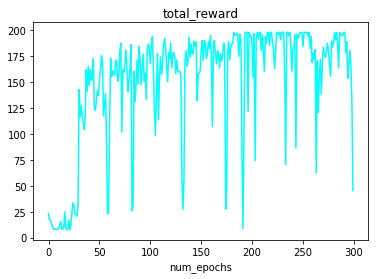

In [0]:
resize = (len(total_rewards)//10, 10)
tmp = np.array(total_rewards, dtype="float32").reshape(resize)
tmp = np.average(tmp, axis=1)
plt.plot(tmp, color="cyan")
plt.xlabel("num_epochs")
plt.title("total_reward")
plt.savefig("My Drive/強化学習/total_rewards.png")
plt.show()

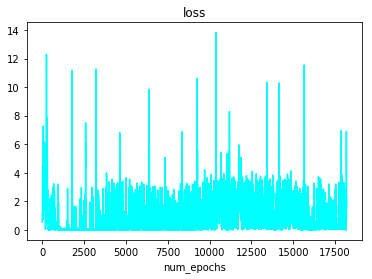

<Figure size 432x288 with 0 Axes>

In [0]:
resize = (len(losses)//10, 10)
tmp = np.array(losses, dtype="float32").reshape(resize)
tmp = np.average(tmp, axis=1)
plt.plot(tmp, color="cyan")
plt.xlabel("num_epochs")
plt.title("loss")
plt.savefig("My Drive/強化学習/loss.png")
plt.show()

# test

In [0]:
pre_obs = env.reset()
step = 0
done = False
total_reward = 0
total_rewards = []
max_step = 200
while not done and step < max_step:
  pre_act = env.action_space.sample()

  # greedy
  if np.random.rand() > epsilon:
    pre_obs_ = np.array(pre_obs, dtype="float32").reshape((1, num_obs))
    pre_obs_ = torch.from_numpy(pre_obs_)
    pre_act = model(pre_obs_)
    _, datas = torch.max(pre_act.data, 1)
    pre_act = datas.numpy()[0]

  obs, reward, done, _ = env.step(pre_act)
  if done:
    reward = -1

  total_reward += reward
  step += 1
  total_step += 1
  pre_obs = obs
  
  total_rewards.append(total_reward)
  

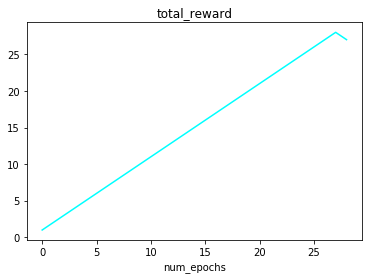

In [0]:
# resize = (len(total_rewards)//10, 10)
# tmp = np.array(total_rewards, dtype="float32").reshape(resize)
tmp = np.array(total_rewards, dtype="float32")
# tmp = np.average(tmp, axis=1)
plt.plot(tmp, color="cyan")
plt.xlabel("num_epochs")
plt.title("total_reward")
plt.show()

In [0]:
import cloudpickle
# 保存
with open('My Drive/強化学習/model1.pkl', 'wb') as f:
    cloudpickle.dump(model, f)